In [1]:
from transformers import ViTImageProcessor
from utils import download_imagenet_labels, overlay, overlay2, overlay3, plot_auc_line, plot_auc_line2, plot_auc_single
import time
from PIL import Image
from sigrate import SIGRATE
import torch.autograd.profiler as profiler
import torch

2025-07-21 12:56:13.877202: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-21 12:56:13.900930: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753095373.917708 1126729 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753095373.921369 1126729 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-21 12:56:13.946385: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

# Parameters

In [2]:
# Image processor for ViT model (only used for resizing image during the plot)
resizer = ViTImageProcessor(do_rescale=False, do_normalize=False)

# URL to download ImageNet labels
imagenet_labels_url = 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt'
class_labels = download_imagenet_labels(imagenet_labels_url)
class_labels_lower = [cls.lower() for cls in class_labels]
imagenet_label_dict = {index: label for index, label in enumerate(class_labels)}

In [3]:
token_ratio = 0.75
masks_layers = 12
starting_layer = 0

# ViT

In [4]:
# Initialize SIGRATE model for ViT
model_vit = SIGRATE('vit', 'cpu')

## Single Image Plot

`ViTSdpaAttention` is used but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


65.71527777777777
65.71527777777777


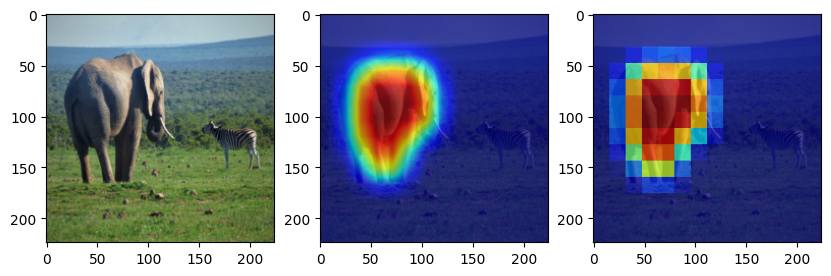

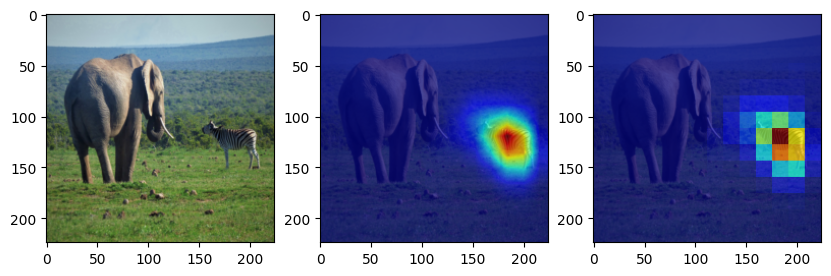

In [5]:
img_path = '../Example_images/tusker-zebra.jpg'

# Open the image using PIL
image = Image.open(img_path).convert('RGB')

# Resize and preprocess the image for the model
img = resizer(image, return_tensors="pt")['pixel_values'][0]

saliency1, label = model_vit.get_saliency(img_path, token_ratio, masks_layers, starting_layer, 101)

saliency2, label = model_vit.get_saliency(img_path, token_ratio, masks_layers, starting_layer, 340)

# Display overlay of image and saliency map
overlay(img, saliency1)

# Display overlay of image and saliency map
overlay(img, saliency2)

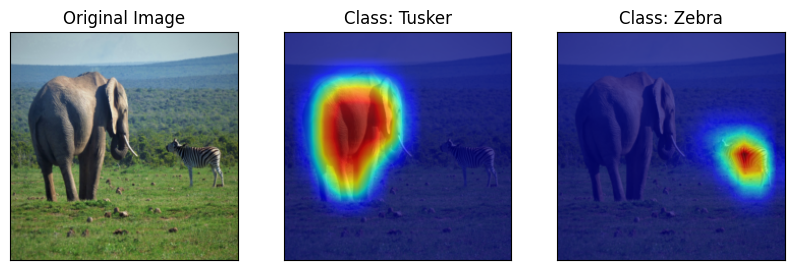

<Figure size 640x480 with 0 Axes>

In [6]:
overlay2(img, saliency1, saliency2, 'Tusker-Zebra')

## Multi image plot with AUC

In [7]:
img_paths = [
            '../Example_images/ski.jpg',
            '../Example_images/spoonbill.jpg',
            '../Example_images/pickup.jpg',
            ]


bbxs_list = [
    # Bounding boxes for image 0 (SKI)
    [(90, 245, 240, 280), (205, 240, 360, 280)],

    # Bounding boxes for image 1 (SPOON)   
    [(130, 40, 425, 380)],
    
    # Bounding boxes for image 2 (PICKUP)
    [(80, 90, 410, 280)],
    
    # Aggiungi altre immagini e bounding box se necessario
]


classe = [
         'ski',
         'spoonbill',
         'pickup',
         ]

# Percentage of patches for insertion and deletion metrics
patch_perc = [i for i in range(1, 100)]

# Baseline for insertion and deletion calculation
baseline = 'black'

71.79861111111111
Time taken: 4.861876010894775


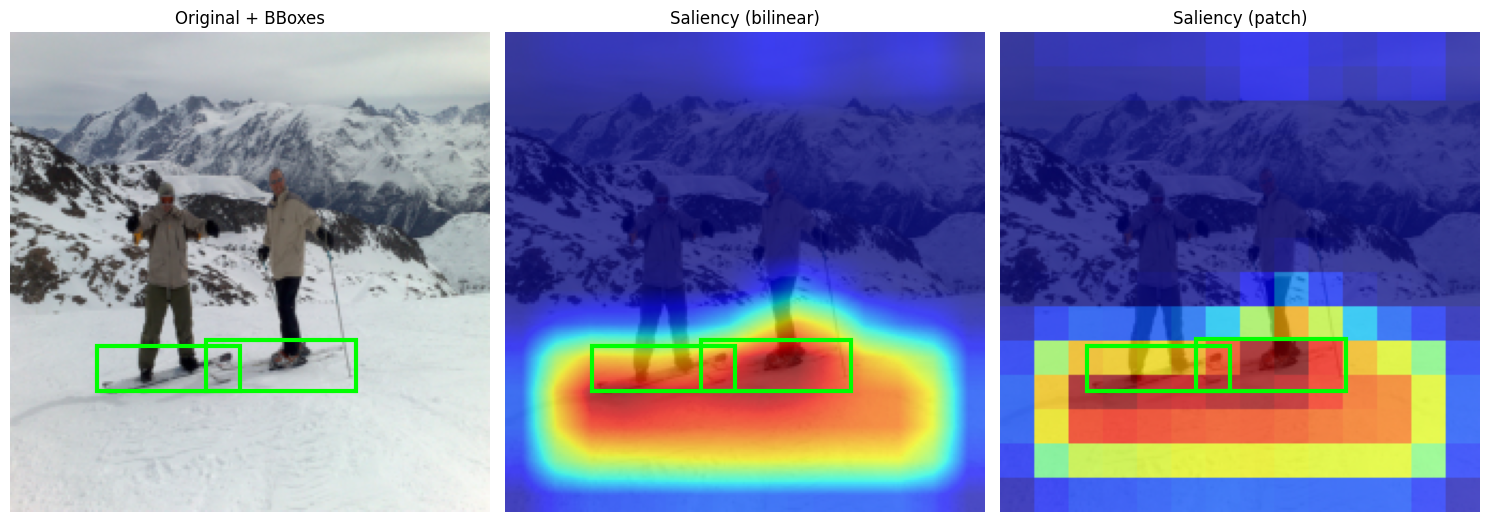

79.89583333333333
Time taken: 5.1224071979522705


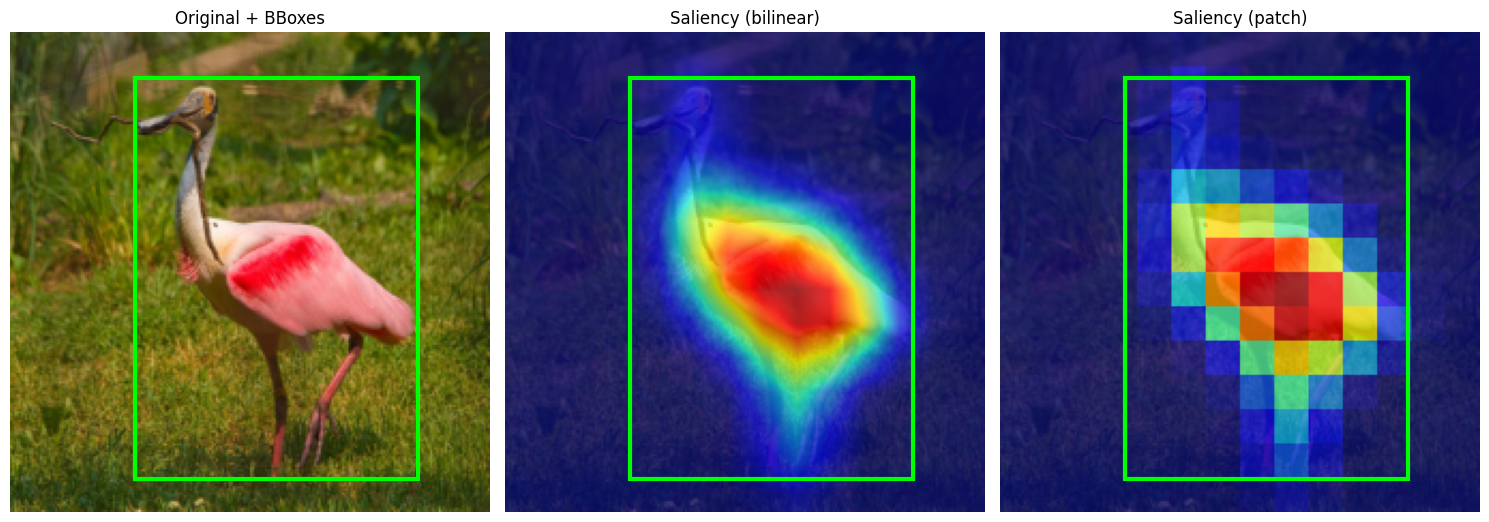

59.770833333333336
Time taken: 4.85910177230835


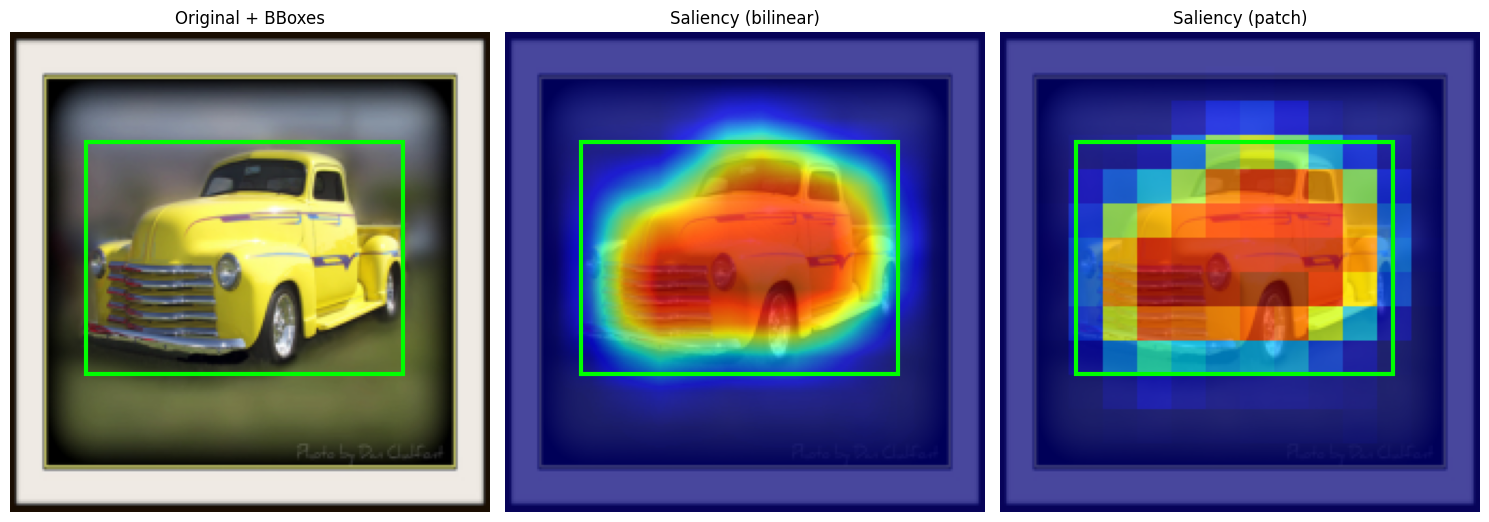

In [8]:
## Lists to store metrics, images, and labels
metrics_list = []
images_list = []
label_list = []
saliency_list = []
bbxs_scaled_list = []

for i in range(len(img_paths)):
    img_path = img_paths[i]
    bbxs = bbxs_list[i]
    start_time = time.time()

    # Saliency e label
    saliency, label = model_vit.get_saliency(img_path, token_ratio, masks_layers, starting_layer)
    print(f'Time taken: {time.time() - start_time}')

    # Caricamento immagine originale
    image = Image.open(img_path).convert('RGB')
    W_orig, H_orig = image.size  # PIL: (width, height)

    # Resize and preprocess for ViT (224x224)
    img_tensor = resizer(image, return_tensors="pt")['pixel_values'][0]
    W_new, H_new = 224, 224  # Target dimensioni

    # Calcola fattori di scala
    scale_x = W_new / W_orig
    scale_y = H_new / H_orig

    # Scala i bounding box
    bbxs_scaled = [
        (
            int(x1 * scale_x), int(y1 * scale_y),
            int(x2 * scale_x), int(y2 * scale_y)
        )
        for (x1, y1, x2, y2) in bbxs
    ]

    # Visualizza overlay
    overlay3(img_tensor, saliency, bbxs_scaled)

    # Calcola metriche
    metrics = model_vit.get_insertion_deletion(patch_perc, saliency, image, baseline, label)

    # Salvataggio
    metrics_list.append(metrics)
    images_list.append(img_tensor)
    label_list.append(imagenet_label_dict[label + 1])
    saliency_list.append(saliency)
    bbxs_scaled_list.append(bbxs_scaled)


In [9]:
# Plot AUC curves for insertion and deletion metrics
plot_auc_single(metrics_list, patch_perc, images_list, label_list, saliency_list, title = f'AUC_ViT', figsize_x = 12, figsize_y = 3, alpha = 0.75, bbxs_scaled_list=bbxs_scaled_list, fontsize =18)

In [ ]:
# with torch.no_grad():
with profiler.profile(record_shapes=True, profile_memory=True, with_flops=True) as prof:
    saliency1, _ = model_vit.get_saliency(img_path, token_ratio, masks_layers, starting_layer, 385)

flops_sum = sum([event.flops for event in prof.key_averages() if event.flops is not None])

print(f"Somma totale di FLOPs: {flops_sum / 1e9:.2f} GFLOPs")

STAGE:2025-07-18 14:23:50 869410:869410 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
[W CPUAllocator.cpp:249] Memory block of unknown size was allocated before the profiling started, profiler results will not include the deallocation event
STAGE:2025-07-18 14:24:12 869410:869410 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2025-07-18 14:24:12 869410:869410 ActivityProfilerController.cpp:324] Completed Stage: Post Processing
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f1685a34790>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


# DeiT

In [10]:
# Initialize SIGRATE model for DeiT
model_deit = SIGRATE('deit', 'cpu')

## Single Image Plot

65.71527777777777
65.71527777777777


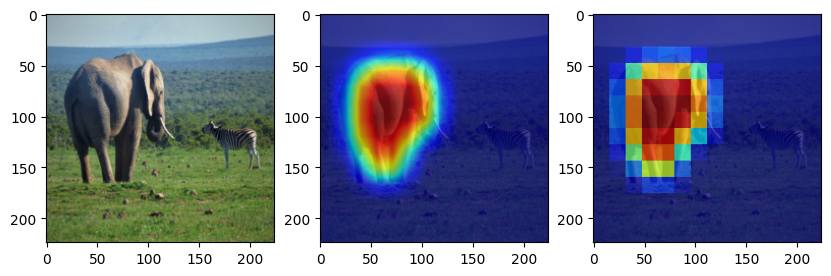

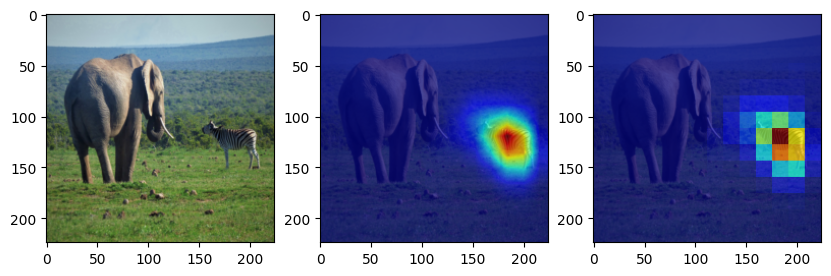

In [11]:
img_path = '../Example_images/tusker-zebra.jpg'

# Open the image using PIL
image = Image.open(img_path).convert('RGB')

# Resize and preprocess the image for the model
img = resizer(image, return_tensors="pt")['pixel_values'][0]

saliency1, label = model_vit.get_saliency(img_path, token_ratio, masks_layers, starting_layer, 101)

saliency2, label = model_vit.get_saliency(img_path, token_ratio, masks_layers, starting_layer, 340)

# Display overlay of image and saliency map
overlay(img, saliency1)

# Display overlay of image and saliency map
overlay(img, saliency2)

## Multi image plot with AUC

In [12]:
# Percentage of patches for insertion and deletion metrics

# Baseline for insertion and deletion calculation
baseline = 'black'

71.79861111111111
Time taken: 4.835320234298706


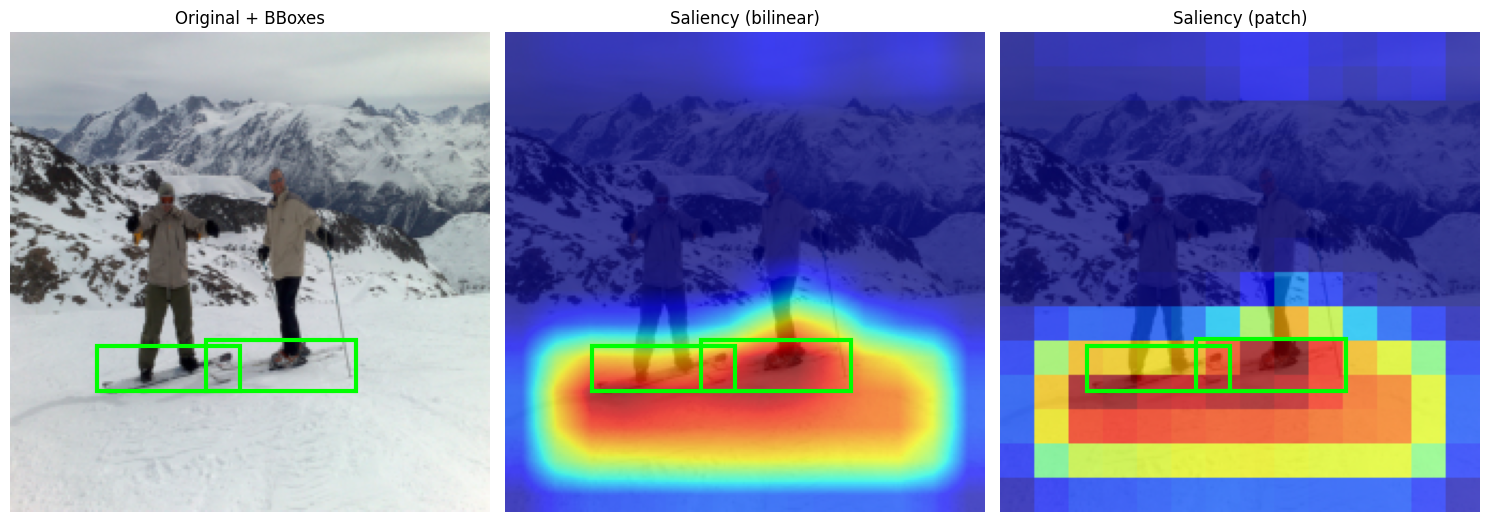

79.89583333333333
Time taken: 4.952486515045166


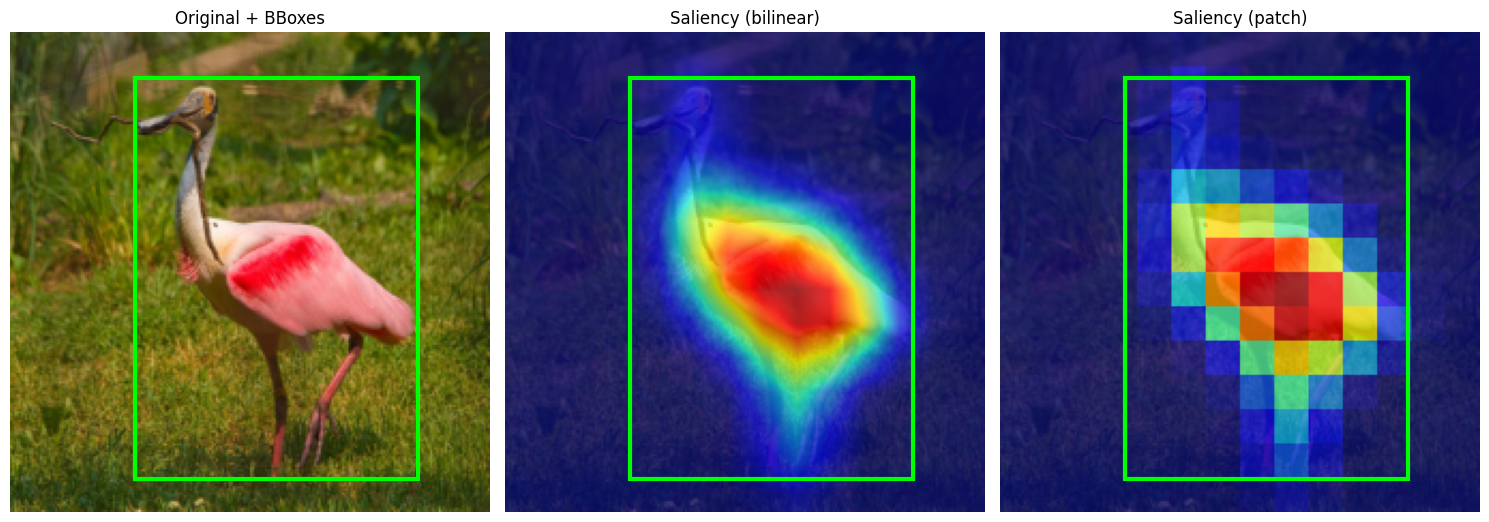

59.770833333333336
Time taken: 5.211026430130005


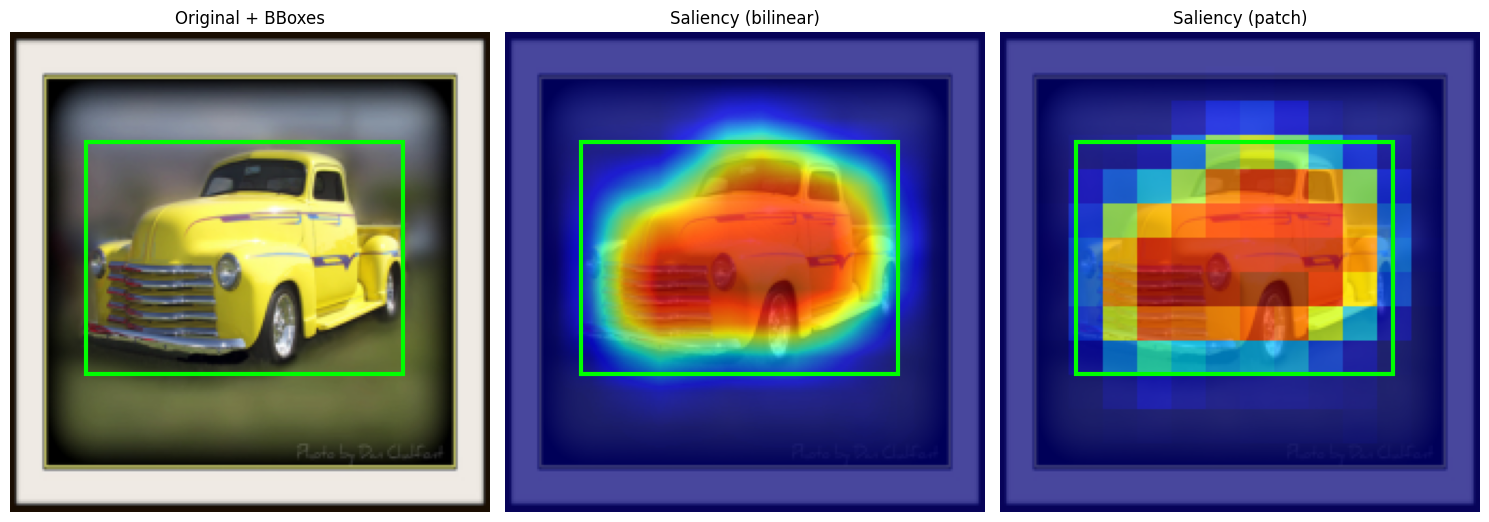

In [13]:
## Lists to store metrics, images, and labels
metrics_list = []
images_list = []
label_list = []
saliency_list = []
bbxs_scaled_list = []

for i in range(len(img_paths)):
    img_path = img_paths[i]
    bbxs = bbxs_list[i]
    start_time = time.time()

    # Saliency e label
    saliency, label = model_vit.get_saliency(img_path, token_ratio, masks_layers, starting_layer)
    print(f'Time taken: {time.time() - start_time}')

    # Caricamento immagine originale
    image = Image.open(img_path).convert('RGB')
    W_orig, H_orig = image.size  # PIL: (width, height)

    # Resize and preprocess for ViT (224x224)
    img_tensor = resizer(image, return_tensors="pt")['pixel_values'][0]
    W_new, H_new = 224, 224  # Target dimensioni

    # Calcola fattori di scala
    scale_x = W_new / W_orig
    scale_y = H_new / H_orig

    # Scala i bounding box
    bbxs_scaled = [
        (
            int(x1 * scale_x), int(y1 * scale_y),
            int(x2 * scale_x), int(y2 * scale_y)
        )
        for (x1, y1, x2, y2) in bbxs
    ]

    # Visualizza overlay
    overlay3(img_tensor, saliency, bbxs_scaled)

    # Calcola metriche
    metrics = model_vit.get_insertion_deletion(patch_perc, saliency, image, baseline, label)

    # Salvataggio
    metrics_list.append(metrics)
    images_list.append(img_tensor)
    label_list.append(imagenet_label_dict[label + 1])
    saliency_list.append(saliency)
    bbxs_scaled_list.append(bbxs_scaled)


In [14]:
# Plot AUC curves for insertion and deletion metrics
plot_auc_single(metrics_list, patch_perc, images_list, label_list, saliency_list, title = f'AUC_DeiT', figsize_x = 12, figsize_y = 3, alpha = 0.75, bbxs_scaled_list=bbxs_scaled_list, fontsize =18)

In [ ]:
with torch.no_grad():
    with profiler.profile(record_shapes=True, profile_memory=True, with_flops=True) as prof:
        saliency1, _ = model_deit.get_saliency(img_path, token_ratio, masks_layers, starting_layer, 385)

flops_sum = sum([event.flops for event in prof.key_averages() if event.flops is not None])

print(f"Somma totale di FLOPs: {flops_sum / 1e9:.2f} GFLOPs")

STAGE:2025-07-21 12:57:52 1126729:1126729 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
`DeiTSdpaAttention` is used but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


64.01388888888889


[W CPUAllocator.cpp:249] Memory block of unknown size was allocated before the profiling started, profiler results will not include the deallocation event
STAGE:2025-07-21 12:58:01 1126729:1126729 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2025-07-21 12:58:01 1126729:1126729 ActivityProfilerController.cpp:324] Completed Stage: Post Processing
